In [43]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [44]:
import numpy as np
import pandas as pd

In [45]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [47]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [48]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [49]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [50]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Part 2 - Exploratory Climate Analysis

([], <a list of 0 Text major ticklabel objects>)

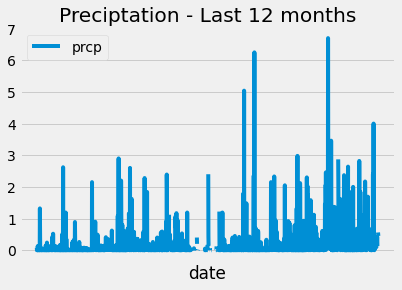

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latestdate = dt.date.fromisoformat(session.query(Measurement).order_by(desc(Measurement.date)).first().date)
oneyearago = latestdate-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement).filter(Measurement.date>oneyearago)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(precipitation.statement, con=engine)
precip_df.set_index('date', inplace=True)
# Sort the dataframe by date
precip_df.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
precip_df_plot = precip_df.drop(['station', 'id','tobs' ], axis =1)
precip_df_plot.plot(grid=True, title='Preciptation - Last 12 months')
plt.xticks([])


In [67]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()                            # counts number of stations
print(f'There are {station_count} stations available in this dataset.')

There are 9 stations available in this dataset.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station)))

active_stations.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_stations.all()[0][0]

lowest_temp = session.query(func.min(Measurement.tobs)).filter_by(station="USC00519281")
print(f' The Lowest tempurature for the most active station is {lowest_temp.first()[0]}.')

highest_temp = session.query(func.max(Measurement.tobs)).filter_by(station="USC00519281")
print(f' The Highest tempurature for the most active station is {highest_temp.first()[0]}.')

average_temp = session.query(func.avg(Measurement.tobs)).filter_by(station="USC00519281")
print(f' The Average tempurature for the most active station is {round(average_temp.first()[0],1)}.')

 The Lowest tempurature for the most active station is 54.0.
 The Highest tempurature for the most active station is 85.0.
 The Average tempurature for the most active station is 71.7.


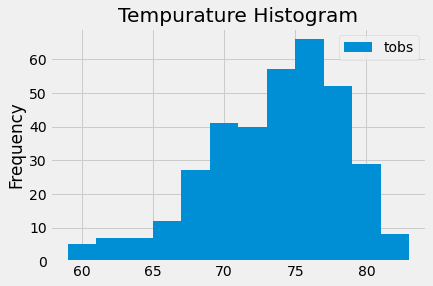

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempurature = session.query(Measurement).filter_by(station="USC00519281").filter(Measurement.date>oneyearago)
tempurature_df = pd.read_sql(tempurature.statement, con=engine)
tempurature_df = tempurature_df.drop(['id', 'prcp'], axis =1)
tempurature_df.plot(kind="hist", bins=12, title = 'Tempurature Histogram')

## Part 3 - Data Analysis Assignment

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [70]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


<ipython-input-71-247814e07990>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


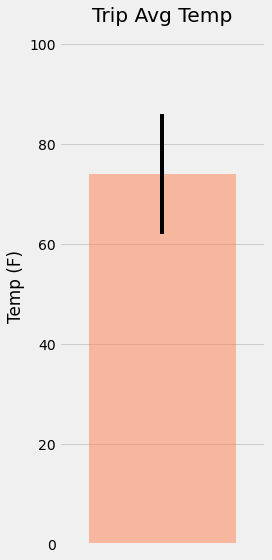

In [71]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,
                         func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >=  "2017-01-01").\
    filter(Measurement.date <= "2017-01-07").group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()
rainfall

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.1525),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.08571428571428572),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.08571428571428572),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.049999999999999996),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.028571428571428574),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

In [86]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [81]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [87]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [89]:
## Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


Text(9.310000000000002, 0.5, 'Temperature')

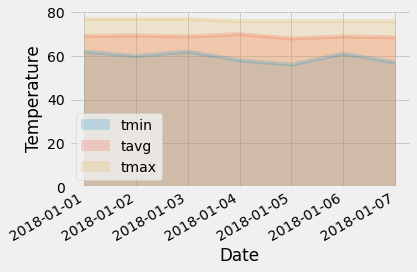

In [90]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")